In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import time
from datetime import datetime, timedelta
from topaz import TopazAPI
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
import requests
import os
import concurrent.futures
import math
api_key = '51066aa1-85af-4f6f-aaa5-08b0f3133af5' #Insert your API key 
topaz_api = TopazAPI(api_key)
import mapping


In [3]:
runs_df = pd.concat([pd.read_feather('server_data/'+x) for x in os.listdir('server_data/')])

C:\Users\Nick\AppData\Local\Temp\ipykernel_5620\31448566.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  runs_df = pd.concat([pd.read_feather('server_data/'+x) for x in os.listdir('server_data/')])


In [4]:
# runs_df = pd.read_feather('server_data/NZ_topaz_race_runs_w_split.fth')

In [5]:
runs_df.isna().sum()

trackCode              0
track                  0
distance               0
raceId                 0
meetingDate            0
                  ...   
position_1       1224256
splitMargin_1    2222451
time_2           2657991
position_2       2657991
splitMargin_2    3080573
Length: 65, dtype: int64

In [6]:
runs_df.raceId.nunique()

350031

In [7]:
runs_df = runs_df.dropna(subset=['place'], how='all')    
runs_df.drop_duplicates(inplace=True)

In [8]:
runs_df.raceId.nunique()

347257

In [9]:
runs_df.shape

(2505633, 65)

In [10]:
runs_df.columns

Index(['trackCode', 'track', 'distance', 'raceId', 'meetingDate',
       'raceTypeCode', 'raceType', 'runId', 'dogId', 'dogName', 'weightInKg',
       'incomingGrade', 'outgoingGrade', 'gradedTo', 'rating', 'raceNumber',
       'boxNumber', 'boxDrawnOrder', 'rugNumber', 'startPrice', 'place',
       'unplaced', 'unplacedCode', 'scratched', 'prizeMoney', 'resultTime',
       'resultMargin', 'resultMarginLengths', 'startPaceCode', 'jumpCode',
       'runLineCode', 'firstSecond', 'colourCode', 'sex', 'comment', 'ownerId',
       'trainerId', 'ownerName', 'ownerState', 'trainerName', 'trainerSuburb',
       'trainerState', 'trainerDistrict', 'trainerPostCode', 'isQuad',
       'isBestBet', 'damId', 'damName', 'sireId', 'sireName', 'dateWhelped',
       'totalFormCount', 'last5', 'isLateScratching', 'bestTime',
       'bestFinishTrackAndDistance', 'pir', 'careerPrizeMoney', 'averageSpeed',
       'time_1', 'position_1', 'splitMargin_1', 'time_2', 'position_2',
       'splitMargin_2'],
     

In [11]:
runs_df.runLineCode.value_counts(dropna=False)

runLineCode
None      1523461
Normal     936725
Wide        37132
Railer       8315
Name: count, dtype: int64

In [12]:
runs_df.startPaceCode.value_counts(dropna=False)

startPaceCode
None    2251365
Fast     192929
Slow      61339
Name: count, dtype: int64

In [13]:
runs_df.jumpCode.value_counts(dropna=False)

jumpCode
None      1523461
Medium     767150
Slow       140890
Quick       74132
Name: count, dtype: int64

In [14]:
runs_df['date'] = pd.to_datetime(runs_df['meetingDate']).dt.date

In [15]:
runs_df['year-month'] = pd.to_datetime(runs_df['meetingDate']).dt.to_period('M')
runs_df['year'] = pd.to_datetime(runs_df['meetingDate']).dt.to_period('Y')

C:\Users\Nick\AppData\Local\Temp\ipykernel_5620\74229333.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  runs_df['year-month'] = pd.to_datetime(runs_df['meetingDate']).dt.to_period('M')
C:\Users\Nick\AppData\Local\Temp\ipykernel_5620\74229333.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  runs_df['year'] = pd.to_datetime(runs_df['meetingDate']).dt.to_period('Y')


In [16]:
runs_df.date.min()

datetime.date(2015, 1, 1)

In [17]:
runs_df.groupby('year')['raceId'].unique().apply(len).value_counts()

raceId
35830    1
36868    1
38038    1
36929    1
36578    1
35348    1
38076    1
38188    1
38982    1
12420    1
Name: count, dtype: int64

In [18]:
# runs_df.to_excel('nz_topaz.xlsx')

In [19]:
TrackDict = {
    'Auckland (NZ)':'Manukau',
    'Christchurch (NZ)':'Addington',
    'Dport @ HOB':'Hobart',
    'Dport @ LCN':'Launceston',
    'Meadows (MEP)':'The Meadows',
    'Otago (NZ)':'Forbury Park',
    'Palmerston Nth (NZ)':'Manawatu',
    'Sandown (SAP)':'Sandown Park',
    'Southland (NZ)':'Ascot Park',
    'Tokoroa (NZ)':'Tokoroa',
    'Waikato (NZ)':'Cambridge',
    'Wanganui (NZ)':'Hatrick',
    'Taranaki (NZ)':'Taranaki',
    'Ashburton (NZ)':'Ashburton',
    'Richmond (RIS)':'Richmond Straight',
    'Murray Bridge (MBR)':'Murray Bridge',
    'Murray Bridge (MBS)':'Murray Bridge Straight'
}

In [20]:
TopazData = runs_df.copy()
TopazData['track'] = TopazData['track'].replace(TrackDict)
TopazData['meetingDate'] = pd.to_datetime(TopazData['meetingDate'])
TopazData['dateWhelped'] = pd.to_datetime(TopazData['dateWhelped'])

TopazData['dogName']=TopazData['dogName'].str.replace("'","")
TopazData['sireName']=TopazData['sireName'].str.replace("'","")
TopazData['damName']=TopazData['damName'].str.replace("'","")

In [21]:
TopazData.raceId.nunique()

347257

In [22]:
state_map = {x['trackName']:x['State'] for x in mapping.trackCodes}

In [23]:
TopazData['state'] = TopazData['track'].map(state_map)

In [24]:
# vicdf = TopazData.query('state  =="VIC"')

In [25]:
# vicdf.runLineCode.value_counts(dropna=False)

In [45]:
pazData[['state', 'track']].value_counts(sort=False)

state  track      
NSW    Armidale        2072
       Bathurst       33163
       Broken Hill     9335
       Bulli          34263
       Canberra       15018
                      ...  
VIC    Shepparton     93459
       The Meadows    82819
       Traralgon      54656
       Warragul       96931
       Warrnambool    61759
Name: count, Length: 66, dtype: int64

In [27]:
TopazData.state.value_counts()

state
VIC    984168
NSW    854571
SA     277832
NZ      71411
Name: count, dtype: int64

In [28]:
TopazData[TopazData['state'].isna()]['track'].unique()

array(['Addington', 'Cambridge', 'Ascot Park', 'Manukau', 'Hatrick',
       'Wellington (NZ)'], dtype=object)

In [29]:
TopazData['state'] = TopazData['state'].fillna('NZ')

In [30]:
# TopazData = TopazData.query('state != "NZ"')

In [31]:
# TopazData['last5'] = TopazData['last5'].astype(str)
scaler = MinMaxScaler()

# # Convert the 'pir' column to string
try:
    TopazData['pir'] = TopazData['pir'].fillna(0)
    TopazData['pir'] = TopazData['pir'].astype(int).astype(str)
except ValueError:
    print('Error converting pir to string')
    TopazData['pir'] = '000'

# # Extract the second last letter and create a new column '2ndLastPIR'
TopazData['2ndLastPIR'] = TopazData['pir'].apply(lambda x: x[-2] if len(x) >= 2 else None)
TopazData['2ndLastPIR'].fillna(TopazData['place'],inplace=True)
TopazData['2ndLastPIR'] = TopazData['2ndLastPIR'].astype(int)

# # Create a feature that calculates places gained/conceded in the home straight
TopazData['finishingPlaceMovement'] = TopazData['2ndLastPIR'] - TopazData['place']

TopazData['weightInKgScaled'] = TopazData.groupby('raceId')['weightInKg'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten() if x.nunique() > 1 else 0)
# TopazData['weightInKgScaled'] = TopazData.groupby('raceId')['weightInKg'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten() if x.nunique() > 1 else 0)
#Scale values as required
TopazData['prizemoneyLog'] = np.log10(TopazData['prizeMoney'] + 1)
TopazData['placeLog'] = np.log10(TopazData['place'] + 1)
TopazData['marginLog'] = np.log10(TopazData['resultMargin'] + 1)

# Calculate median winner time per track/distance
win_results = TopazData[TopazData['place'] == 1]

grouped_data = win_results.groupby(['track', 'distance', 'meetingDate'])['resultTime'].median().reset_index()

median_win_time = pd.DataFrame(grouped_data.groupby(['track', 'distance']).apply(lambda x: x.sort_values('meetingDate').set_index('meetingDate')['resultTime'].shift(1).rolling('365D', min_periods=1).median())).reset_index()
median_win_time.rename(columns={"resultTime": "runTimeMedian"},inplace=True)

median_win_time['speedIndex'] = (median_win_time['runTimeMedian'] / median_win_time['distance'])
median_win_time['speedIndex'] = MinMaxScaler().fit_transform(median_win_time[['speedIndex']])

TopazData = TopazData.merge(median_win_time, how='left', on=['track', 'distance','meetingDate'])

TopazData['runTimeNorm'] = (TopazData['runTimeMedian'] / TopazData['resultTime']).clip(0.8, 1.2)
TopazData['runTimeNorm'] = MinMaxScaler().fit_transform(TopazData[['runTimeNorm']])

#Same for split time
split_win_results = TopazData[TopazData['position_1'] == 1]
grouped_data = split_win_results.groupby(['track', 'distance', 'meetingDate'])['time_1'].median().reset_index()

median_split_win_time = pd.DataFrame(grouped_data.groupby(['track', 'distance']).apply(lambda x: x.sort_values('meetingDate').set_index('meetingDate')['time_1'].shift(1).rolling('365D', min_periods=1).median())).reset_index()
median_split_win_time.rename(columns={'time_1': 'split_time_median'},inplace=True)

median_split_win_time['split_speedIndex'] = median_split_win_time['split_time_median']
median_split_win_time['split_speedIndex'] = MinMaxScaler().fit_transform(median_split_win_time[['split_time_median']])

# Merge with median winner time
TopazData = TopazData.merge(median_split_win_time, how='left', on=['track', 'distance','meetingDate'])

# Normalise time comparison
TopazData['split_runTimeNorm'] = (TopazData['split_time_median'] / TopazData['time_1']).clip(0.5, 1.5)
TopazData['split_runTimeNorm'] = MinMaxScaler().fit_transform(TopazData[['split_runTimeNorm']])
min_run_time = TopazData.groupby('raceId')[['time_1']].min().reset_index().rename(columns={'time_1':'min_run_time'})
TopazData = TopazData.merge(min_run_time, on='raceId')
TopazData['split_time_margin'] = TopazData['time_1']-TopazData['min_run_time']
# Same for runhome time
TopazData['run_home_time'] = TopazData['resultTime'] - TopazData['time_1']
win_results = TopazData[TopazData['place'] == 1]


grouped_data = win_results.groupby(['track', 'distance', 'meetingDate'])['run_home_time'].median().reset_index()

median_win_time = pd.DataFrame(grouped_data.groupby(['track', 'distance']).apply(lambda x: x.sort_values('meetingDate').set_index('meetingDate')['run_home_time'].shift(1).rolling('365D', min_periods=1).median())).reset_index()
median_win_time.rename(columns={'run_home_time': "run_home_TimeMedian"},inplace=True)

median_win_time['run_home_speedIndex'] = (median_win_time['run_home_TimeMedian'] / median_win_time['distance'])
median_win_time['run_home_speedIndex'] = MinMaxScaler().fit_transform(median_win_time[['run_home_speedIndex']])

TopazData = TopazData.merge(median_win_time, how='left', on=['track', 'distance','meetingDate'])

TopazData['run_home_TimeNorm'] = (TopazData['run_home_TimeMedian'] / TopazData['run_home_time']).clip(0.8, 1.2)
TopazData['run_home_TimeNorm'] = MinMaxScaler().fit_transform(TopazData[['runTimeNorm']])

# Sort the DataFrame by 'RaceId' and 'Box'
TopazData = TopazData.sort_values(by=['raceId', 'boxNumber'])

# Check if there is an entry equal to boxNumber + 1
TopazData['hasEntryBoxNumberPlus1'] = (TopazData.groupby('raceId')['boxNumber'].shift(1) == TopazData['boxNumber'] + 1) | (TopazData['boxNumber'] == 8)
TopazData['hasEntryBoxNumberMinus1'] = (TopazData.groupby('raceId')['boxNumber'].shift(-1) == TopazData['boxNumber'] - 1)
# Convert boolean values to 1
TopazData['hasEntryBoxNumberPlus1'] = TopazData['hasEntryBoxNumberPlus1'].astype(int)
TopazData['hasEntryBoxNumberMinus1'] = TopazData['hasEntryBoxNumberMinus1'].astype(int)
# Display the resulting DataFrame which shows adjacent Vacant Boxes
# Box 1 is treated as having a vacant box to the left always as we are looking how much space the dog has to move.
TopazData['adjacentVacantBoxes'] = 2 - TopazData['hasEntryBoxNumberPlus1'] - TopazData['hasEntryBoxNumberMinus1']
# Calculate 'hasAtLeast1VacantBox'
TopazData['hasAtLeast1VacantBox'] = (TopazData['adjacentVacantBoxes'] > 0).astype(int)

TopazData['win'] = TopazData['place'].apply(lambda x: 1 if x == 1 else 0)

grouped_data = TopazData.groupby(['track', 'distance', 'boxNumber', 'hasAtLeast1VacantBox', 'meetingDate'])['win'].mean().reset_index()
grouped_data.set_index('meetingDate', inplace=True)

# Apply rolling mean calculation to the aggregated data
box_win_percent = grouped_data.groupby(['track', 'distance', 'boxNumber', 'hasAtLeast1VacantBox']).apply(lambda x: x.sort_values('meetingDate')['win'].shift(1).rolling('365D', min_periods=1).mean()).reset_index()

# Reset index and rename columns
box_win_percent.columns = ['track', 'distance', 'boxNumber', 'hasAtLeast1VacantBox', 'meetingDate', 'rolling_box_win_percentage']

# Add to dog results dataframe
TopazData = TopazData.merge(box_win_percent, on=['track', 'distance', 'meetingDate','boxNumber','hasAtLeast1VacantBox'], how='left')

# resultMargin has the same value for 1st and 2nd placed dogs, but should be 0 for the 1st placed dog.
TopazData.loc[TopazData['place'] == 1, ['resultMargin']] = 0

TopazData['dogAge'] = (TopazData['meetingDate'] - TopazData['dateWhelped']).dt.days
scaler = MinMaxScaler()
TopazData['dogAgeScaled'] = TopazData.groupby('raceId')['dogAge'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
TopazData['averageSpeed'] = TopazData['distance'] / TopazData['resultTime']

Error converting pir to string


In [32]:
TopazData.speedIndex

0          0.934934
1          0.934934
2          0.934934
3          0.934934
4          0.934934
             ...   
2505628    0.920733
2505629    0.920733
2505630    0.920733
2505631    0.920733
2505632    0.920733
Name: speedIndex, Length: 2505633, dtype: float64

In [33]:
TopazData['averageSpeed'] = TopazData['distance'] / TopazData['resultTime']
TopazData['splitMargin_1'] = np.where(TopazData['position_1'] == 1, 0, TopazData['splitMargin_1'])
TopazData['margin_from_lengths'] = pd.to_numeric(TopazData['resultMarginLengths'].str.replace('L',''))
# TopazData['win']

In [34]:
TopazData['resultMargin'] = TopazData['margin_from_lengths']

In [35]:
TopazData.shape

(2505633, 96)

In [36]:
TopazData.margin_from_lengths

0           5.00
1          15.75
2          24.00
3          22.00
4           9.50
           ...  
2505628     9.75
2505629     7.75
2505630     7.25
2505631     6.25
2505632     1.25
Name: margin_from_lengths, Length: 2505633, dtype: float64

In [37]:
TopazData.columns

Index(['trackCode', 'track', 'distance', 'raceId', 'meetingDate',
       'raceTypeCode', 'raceType', 'runId', 'dogId', 'dogName', 'weightInKg',
       'incomingGrade', 'outgoingGrade', 'gradedTo', 'rating', 'raceNumber',
       'boxNumber', 'boxDrawnOrder', 'rugNumber', 'startPrice', 'place',
       'unplaced', 'unplacedCode', 'scratched', 'prizeMoney', 'resultTime',
       'resultMargin', 'resultMarginLengths', 'startPaceCode', 'jumpCode',
       'runLineCode', 'firstSecond', 'colourCode', 'sex', 'comment', 'ownerId',
       'trainerId', 'ownerName', 'ownerState', 'trainerName', 'trainerSuburb',
       'trainerState', 'trainerDistrict', 'trainerPostCode', 'isQuad',
       'isBestBet', 'damId', 'damName', 'sireId', 'sireName', 'dateWhelped',
       'totalFormCount', 'last5', 'isLateScratching', 'bestTime',
       'bestFinishTrackAndDistance', 'pir', 'careerPrizeMoney', 'averageSpeed',
       'time_1', 'position_1', 'splitMargin_1', 'time_2', 'position_2',
       'splitMargin_2', 'date'

In [38]:
def rolling_last(x):
    return x.iloc[-1]

In [39]:
import itertools

dataset = TopazData.copy()
print(f"dataset shape: {dataset.shape}")
dataset['meetingDate'] = pd.to_datetime(dataset['meetingDate'])

# Calculate values for dog, trainer, dam and sire
subsets = ['dog', 'trainer', 'dam', 'sire']
# subsets = ['dog']

# Use rolling window of 28, 91 and 365 days
# rolling_windows = ['28D','91D', '365D']
rolling_windows = [1,'28D','91D', '365D']
rolling_windows = [1,'365D']
# rolling_windows = [1]

# Features to use for rolling windows calculation
# features = ['distance','boxNumber','runTimeNorm', 'placeLog', 'prizemoneyLog', 
#             'marginLog','finishingPlaceMovement','splitMargin_1','split_runTimeNorm','run_home_TimeNorm','finishingPlaceMovement',
#             'time_1','averageSpeed']

features = ['distance','boxNumber','runTimeNorm', 'place', 'resultMargin',
            'split_time_margin','split_runTimeNorm','time_1','run_home_TimeNorm','finishingPlaceMovement',
            'averageSpeed', 'win']


# dam_features = ['distance','boxNumber','runTimeNorm', 'place', 'resultMargin','split_time_margin','split_runTimeNorm',
#             'time_1','averageSpeed', 'win']


# Aggregation functions to apply

aggregates = ['mean']

# Keep track of generated feature names
feature_cols = []

for i in subsets:
    # Generate rolling window features
    idnumber = i + 'Id'

    subset_dataframe = dataset[['meetingDate',idnumber] + features]
    average_df = pd.DataFrame()

    for feature in features:
        # Group by 'damId' and 'meetingDate' and calculate the average of the current feature
        feature_average_df = subset_dataframe.groupby([idnumber, 'meetingDate'])[feature].mean().reset_index()
        # Rename the feature column to indicate it's the average of that feature
        feature_average_df.rename(columns={feature: f'{feature}{i}DayAverage'}, inplace=True)

        # If average_df is empty, assign the feature_average_df to it
        if average_df.empty:
            average_df = feature_average_df
        else:
            # Otherwise, merge feature_average_df with average_df
            average_df = pd.merge(average_df, feature_average_df, on=[idnumber, 'meetingDate'],how='left')

        # Assuming df is your DataFrame
    column_names = average_df.columns.tolist()
    # Columns to exclude
    columns_to_exclude = [idnumber,'meetingDate']
    # Exclude specified columns from the list
    column_names_filtered = [col for col in column_names if col not in columns_to_exclude]

    average_df.drop_duplicates(inplace=True)
    average_df['meetingDate'] = pd.to_datetime(average_df['meetingDate'])
    average_df = average_df.set_index([idnumber, 'meetingDate']).sort_index() 


    #Process Dog Stats
    for rolling_window in rolling_windows:
        print(f"dataset shape: {dataset.shape}")
        print(f'Processing {i} rolling window {rolling_window} days')

        rolling_result = (
            average_df
            .reset_index(level=0)
            .groupby(idnumber)[column_names_filtered]
            .rolling(rolling_window)  # Use timedelta for rolling window
            .agg(aggregates)
            .groupby(level=0)
            .shift(1)
        )

        # Generate list of rolling window feature names (eg: RunTime_norm_min_365D)
        agg_features_cols = [f'{i}_{f}_{a}_{rolling_window}' for f, a in itertools.product(features, aggregates)]
        # Add features to dataset
        average_df[agg_features_cols] = rolling_result
        # Keep track of generated feature names
        feature_cols.extend(agg_features_cols)
        average_df.fillna(0, inplace=True)

    

    average_df.reset_index(inplace=True)
    dataset = pd.merge(dataset,average_df,on=[idnumber, 'meetingDate'],how='left')

# Only keep data 12 months after the start date of your dataset since we've used a 365D rolling timeframe for some features
# feature_cols = np.unique(feature_cols).tolist()
# dataset = dataset[dataset['meetingDate'] >= '2021-01-01']

dataset = dataset[[
                'meetingDate',
                'state',
                'track',
                'distance',
                'raceId',
                'raceTypeCode',
                'raceNumber',
                'boxNumber',
                'rugNumber',
                'runId',
                'dogId',
                'dogName',
                'weightInKg',
                'sex',
                'trainerId',
                'trainerState',
                'damId',
                'damName',
                'sireId',
                'sireName',
                'win',
                'place',
                'resultTime',
                'resultMargin',
                'resultMarginLengths',
                'dogAgeScaled',
                'startPrice',
                # 'lastFiveWinPercentage',
                # 'lastFivePlacePercentage',
                'weightInKgScaled',
                'rolling_box_win_percentage',
                'hasEntryBoxNumberPlus1', 
                'hasEntryBoxNumberMinus1',]
                 + feature_cols
                ]

feature_cols.extend(['dogAgeScaled',
                     'boxNumber',
                # 'lastFiveWinPercentage',
                # 'lastFivePlacePercentage',
                'weightInKgScaled',
                'hasEntryBoxNumberPlus1', 'hasEntryBoxNumberMinus1',
                'rolling_box_win_percentage'])

#The below line will output your dataframe to a csv but may be too large to open in Excel.
#dataset.to_csv('testing.csv',index=False)

dataset shape: (2505633, 96)
dataset shape: (2505633, 96)
Processing dog rolling window 1 days
dataset shape: (2505633, 96)
Processing dog rolling window 365D days
dataset shape: (2505633, 132)
Processing trainer rolling window 1 days
dataset shape: (2505633, 132)
Processing trainer rolling window 365D days
dataset shape: (2505633, 168)
Processing dam rolling window 1 days
dataset shape: (2505633, 168)
Processing dam rolling window 365D days
dataset shape: (2505633, 204)
Processing sire rolling window 1 days
dataset shape: (2505633, 204)
Processing sire rolling window 365D days


In [40]:
feature_cols = ['dogAgeScaled',
                     'boxNumber',
                # 'lastFiveWinPercentage',
                # 'lastFivePlacePercentage',
                'weightInKgScaled',
                'hasEntryBoxNumberPlus1', 'hasEntryBoxNumberMinus1',
                'rolling_box_win_percentage'] + [x for x in feature_cols if (('dog' in x) and ('_1' in x)) or (('dog' not in x) and ('_365' in x))]
feature_cols

['dogAgeScaled',
 'boxNumber',
 'weightInKgScaled',
 'hasEntryBoxNumberPlus1',
 'hasEntryBoxNumberMinus1',
 'rolling_box_win_percentage',
 'dog_distance_mean_1',
 'dog_boxNumber_mean_1',
 'dog_runTimeNorm_mean_1',
 'dog_place_mean_1',
 'dog_resultMargin_mean_1',
 'dog_split_time_margin_mean_1',
 'dog_split_runTimeNorm_mean_1',
 'dog_time_1_mean_1',
 'dog_run_home_TimeNorm_mean_1',
 'dog_finishingPlaceMovement_mean_1',
 'dog_averageSpeed_mean_1',
 'dog_win_mean_1',
 'dog_time_1_mean_365D',
 'trainer_distance_mean_365D',
 'trainer_boxNumber_mean_365D',
 'trainer_runTimeNorm_mean_365D',
 'trainer_place_mean_365D',
 'trainer_resultMargin_mean_365D',
 'trainer_split_time_margin_mean_365D',
 'trainer_split_runTimeNorm_mean_365D',
 'trainer_time_1_mean_365D',
 'trainer_run_home_TimeNorm_mean_365D',
 'trainer_finishingPlaceMovement_mean_365D',
 'trainer_averageSpeed_mean_365D',
 'trainer_win_mean_365D',
 'dam_distance_mean_365D',
 'dam_boxNumber_mean_365D',
 'dam_runTimeNorm_mean_365D',
 'dam_

In [41]:
feature_cols = ['dogAgeScaled',
 'boxNumber',
 'weightInKgScaled',
 'hasEntryBoxNumberPlus1',
 'hasEntryBoxNumberMinus1',
 'rolling_box_win_percentage',
 'dog_distance_mean_1',
 'dog_boxNumber_mean_1',
 'dog_runTimeNorm_mean_1',
 'dog_place_mean_1',
 'dog_resultMargin_mean_1',
 'dog_split_time_margin_mean_1',
 'dog_split_runTimeNorm_mean_1',
 'dog_time_1_mean_1',
 'dog_run_home_TimeNorm_mean_1',
 'dog_finishingPlaceMovement_mean_1',
 'dog_averageSpeed_mean_1',
 'dog_win_mean_1',
 'trainer_distance_mean_365D',
 'trainer_boxNumber_mean_365D',
 'trainer_runTimeNorm_mean_365D',
 'trainer_place_mean_365D',
 'trainer_resultMargin_mean_365D',
 'trainer_split_time_margin_mean_365D',
 'trainer_split_runTimeNorm_mean_365D',
 'trainer_time_1_mean_365D',
 'trainer_run_home_TimeNorm_mean_365D',
 'trainer_finishingPlaceMovement_mean_365D',
 'trainer_averageSpeed_mean_365D',
 'trainer_win_mean_365D',
 'dam_distance_mean_365D',
 'dam_boxNumber_mean_365D',
 'dam_runTimeNorm_mean_365D',
 'dam_place_mean_365D',
 'dam_resultMargin_mean_365D',
 'dam_split_time_margin_mean_365D',
 'dam_split_runTimeNorm_mean_365D',
 'dam_time_1_mean_365D',
 'dam_run_home_TimeNorm_mean_365D',
 'dam_finishingPlaceMovement_mean_365D',
 'dam_averageSpeed_mean_365D',
 'dam_win_mean_365D',
 'sire_distance_mean_365D',
 'sire_boxNumber_mean_365D',
 'sire_runTimeNorm_mean_365D',
 'sire_place_mean_365D',
 'sire_resultMargin_mean_365D',
 'sire_split_time_margin_mean_365D',
 'sire_split_runTimeNorm_mean_365D',
 'sire_time_1_mean_365D',
 'sire_run_home_TimeNorm_mean_365D',
 'sire_finishingPlaceMovement_mean_365D',
 'sire_averageSpeed_mean_365D',
 'sire_win_mean_365D']

In [42]:
single_dog = dataset.query('dogId == 409540106')
single_dog

,meetingDate,state,track,distance,raceId,raceTypeCode,raceNumber,boxNumber,rugNumber,runId,...,sire_runTimeNorm_mean_365D,sire_place_mean_365D,sire_resultMargin_mean_365D,sire_split_time_margin_mean_365D,sire_split_runTimeNorm_mean_365D,sire_time_1_mean_365D,sire_run_home_TimeNorm_mean_365D,sire_finishingPlaceMovement_mean_365D,sire_averageSpeed_mean_365D,sire_win_mean_365D
0,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,1.0,1,-2147327190,...,0.451004,4.404901,7.686900,0.204147,0.475305,7.217070,0.451004,-4.404901,17.127149,0.125429
78207,2016-07-20 00:00:00+00:00,VIC,The Meadows,600,135714891,5,9,4.0,4,135715419,...,0.451144,4.418941,7.697905,0.204268,0.474689,7.228547,0.451144,-4.418941,17.417356,0.124436
84207,2016-07-27 00:00:00+00:00,VIC,Cranbourne,699,137740448,RW,6,1.0,1,137741100,...,0.451088,4.422065,7.711477,0.206205,0.474571,7.225332,0.451088,-4.422065,17.416116,0.123997
107297,2016-08-28 00:00:00+00:00,VIC,Sale,650,147290998,RW,5,3.0,3,147291536,...,0.450966,4.419509,7.753891,0.209483,0.473869,7.245563,0.450966,-4.419509,17.418844,0.124773
110477,2016-09-03 00:00:00+00:00,VIC,Traralgon,595,149013437,SH,5,6.0,6,149013984,...,0.450929,4.416178,7.765306,0.209473,0.473849,7.242692,0.450929,-4.416178,17.463236,0.124964
124043,2016-09-12 00:00:00+00:00,VIC,Traralgon,665,151806012,RW,6,7.0,7,151806568,...,0.450818,4.411839,7.772781,0.209406,0.473717,7.241547,0.450818,-4.411839,17.461364,0.125619
128653,2016-09-25 00:00:00+00:00,VIC,Sale,650,155626133,S,6,5.0,5,155626651,...,0.450656,4.410992,7.797546,0.211030,0.473608,7.245278,0.450656,-4.410992,17.459042,0.126480
133169,2016-10-01 00:00:00+00:00,VIC,Traralgon,525,157423242,S,4,7.0,7,157423956,...,0.450578,4.410746,7.806024,0.211333,0.473548,7.242397,0.450578,-4.410746,17.458621,0.126032
145522,2016-10-16 00:00:00+00:00,VIC,Sale,520,161894154,X45,6,8.0,8,161894759,...,0.450596,4.406689,7.819461,0.214622,0.473254,7.254767,0.450596,-4.406689,17.458250,0.126410
149276,2016-10-22 00:00:00+00:00,VIC,Traralgon,595,163357585,X45,6,1.0,1,163358258,...,0.450666,4.401353,7.815623,0.215554,0.473088,7.253757,0.450666,-4.401353,17.414257,0.126868


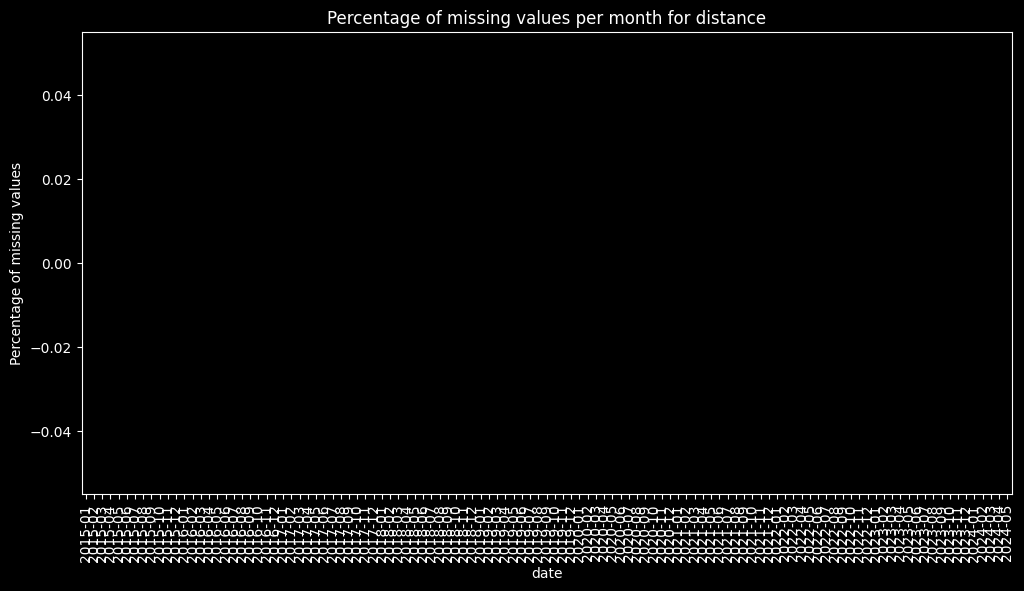

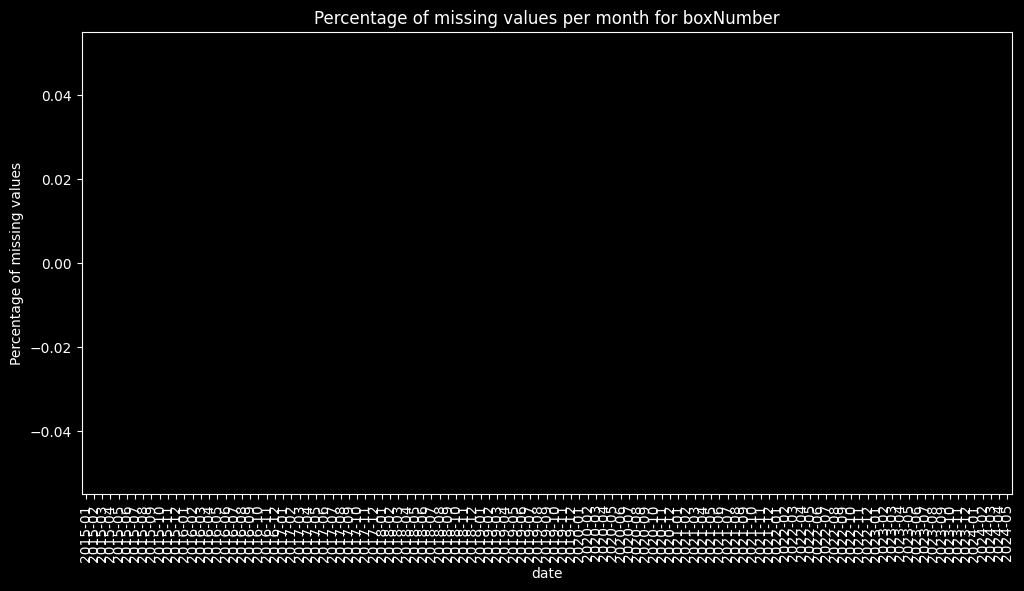

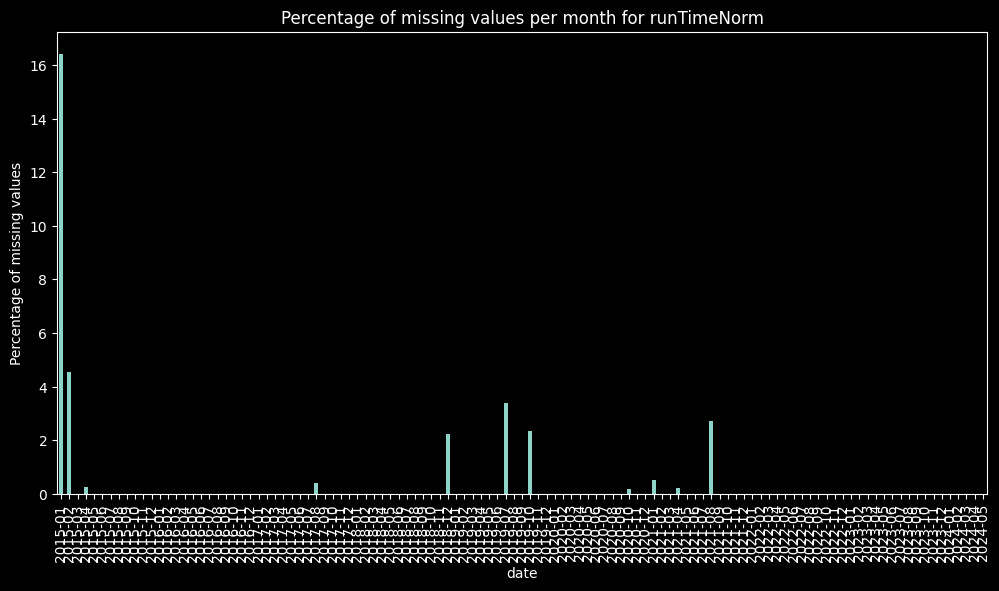

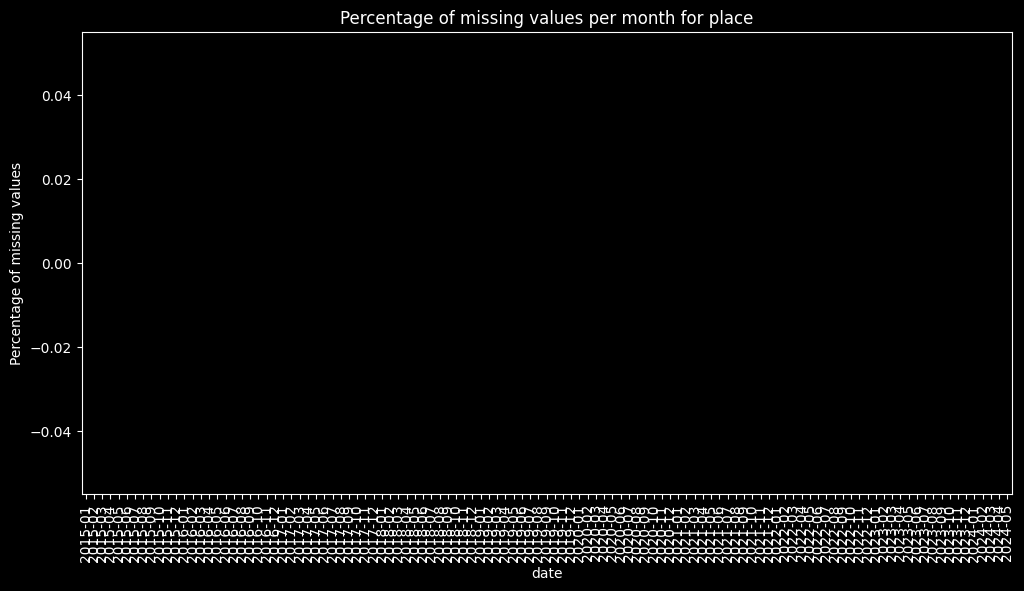

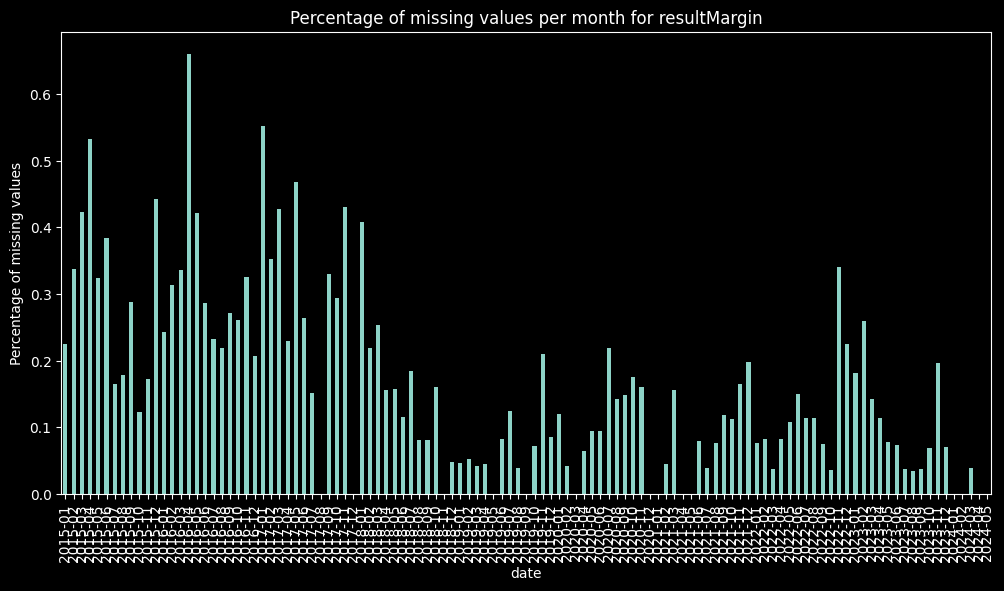

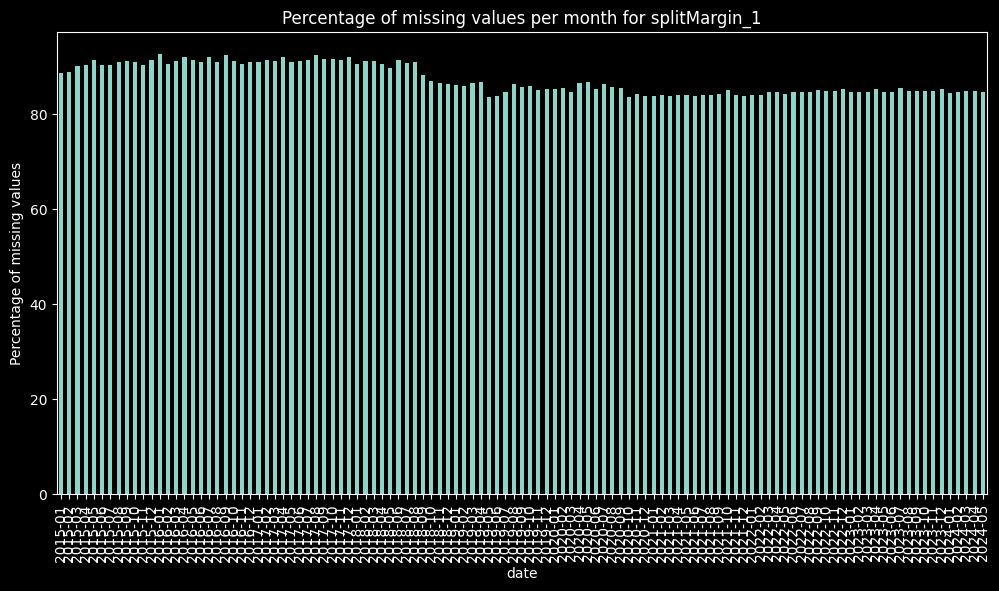

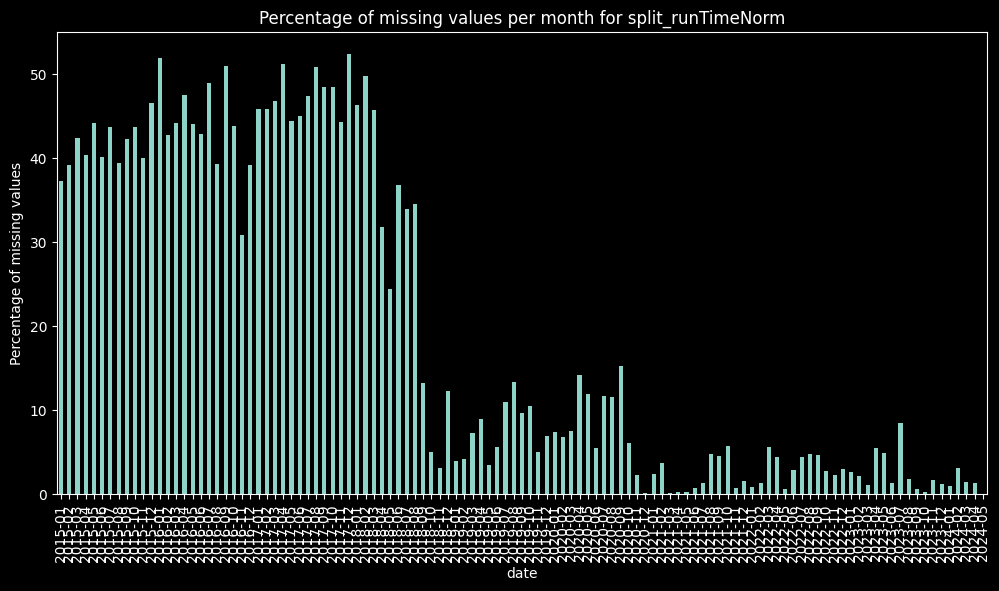

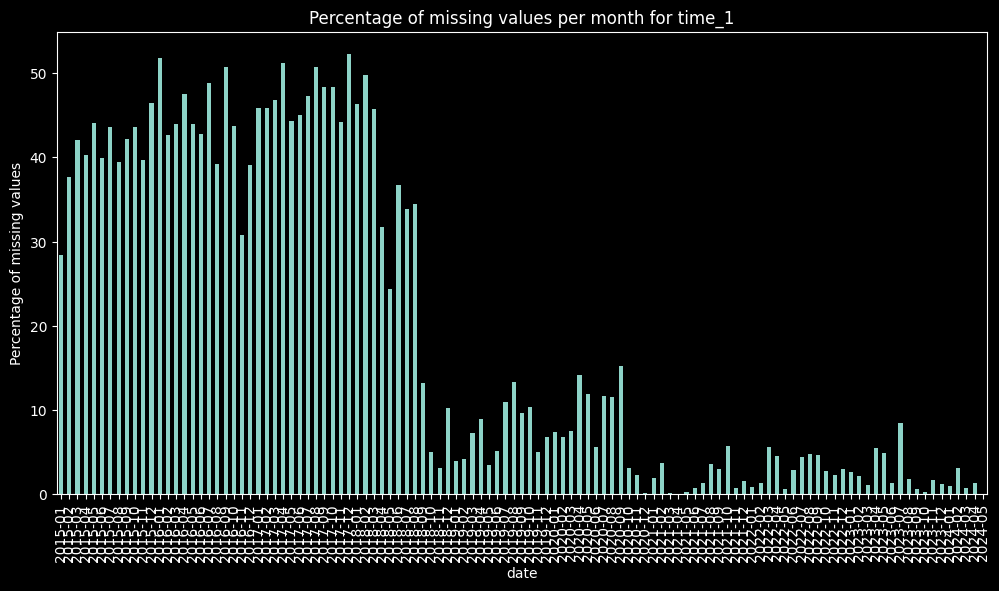

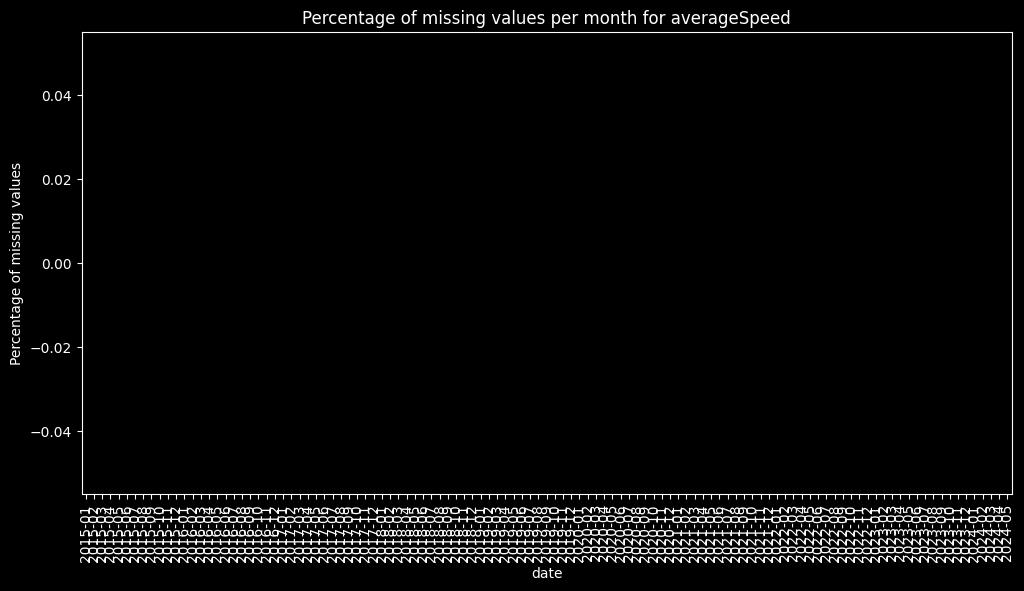

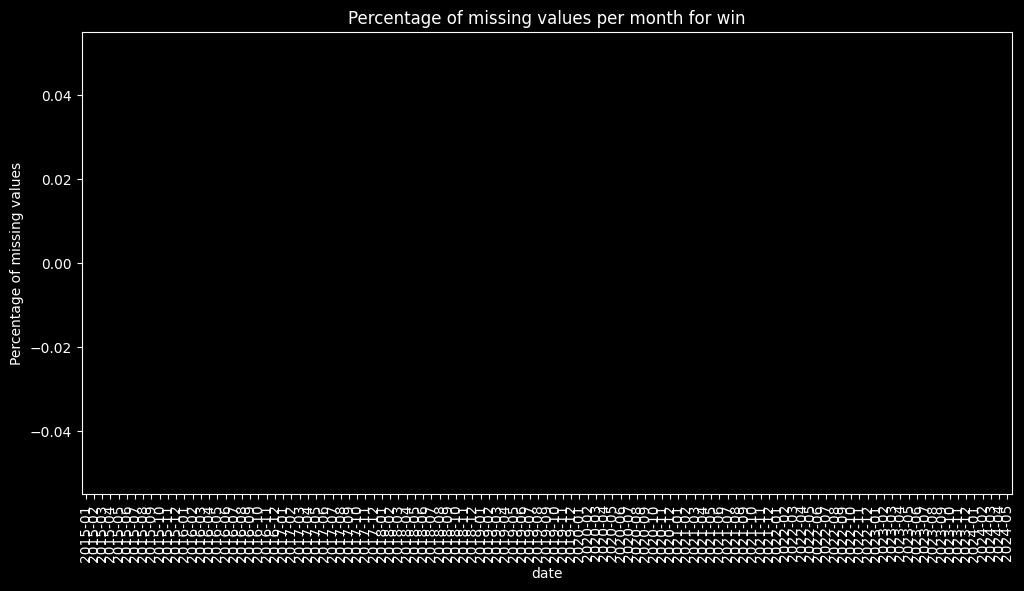

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df is your DataFrame and 'date' is your date column
df = TopazData.query('state == "SA"').copy()
df['date'] = pd.to_datetime(df['date']).dt.to_period('M')

# List of relevant columns
columns = ['distance','boxNumber','runTimeNorm', 'place', 'resultMargin','splitMargin_1','split_runTimeNorm',
            'time_1','averageSpeed', 'win']  # replace with your actual column names

# Create a separate plot for each column
for col in columns:
    # Group by 'date' and calculate the percentage of missing values in each month for the column
    missing_data = df.groupby('date')[col].apply(lambda x: x.isnull().mean() * 100)

    # Plot the results
    missing_data.plot(kind='bar', figsize=(12, 6))
    plt.title(f'Percentage of missing values per month for {col}')
    plt.ylabel('Percentage of missing values')
    plt.show()

In [43]:
dataset.to_feather('topaz_data_dog.fth')

In [44]:
dataset.dogName

0             BUREKUP JACK
1           GALLOPING EMMA
2               DIEGONATOR
3                POPPY JAY
4             LEOPARDSTOWN
                ...       
2505628         HARD ON ME
2505629        IRISH NIKKI
2505630         RILEY COIN
2505631       CLASSY KAYLA
2505632    DAINTREE DAMAGE
Name: dogName, Length: 2505633, dtype: object

In [45]:
betfair_df = pd.read_feather('../data_tools/DATA/df-betfairSP.fth')

In [46]:
betfair_df['date'] =  (pd.to_datetime(betfair_df['EVENT_DT'],dayfirst=True) + pd.Timedelta(hours=7)).dt.date
betfair_df['dogName'] = betfair_df.dog.str.strip().str.upper().str.replace('.','').replace("'",'')
# betfair_df.to_csv('betfair_bsp.csv')

In [50]:
dataset['date'] = pd.to_datetime(dataset['meetingDate']).dt.date
dataset['dogName'] = dataset['dogName'].str.upper().str.replace('.','').str.replace("'",'')

In [48]:
dataset_bsp = dataset.merge(betfair_df,on=['date','dogName'],how='left')

In [49]:
betfair_df.columns

Index(['EVENT_ID', 'EVENT_DT', 'SELECTION_ID', 'BSP', 'dog', 'MENU_HINT',
       'date', 'dogName'],
      dtype='object')

In [52]:
def generate_prev_race(df_in, df_g, rolling_window=10, factor=''):
    df = df_in.copy()
    original_cols = df_in.columns
    df[f'prev_race'] = df_g['raceId'].shift(1).fillna('-1').astype('string')
    df[f'prev_race_date'] = df_g['date'].shift(1).fillna('-1').astype('string')
    df[f'prev_race_track'] = df_g['track'].shift(1).fillna('-1').astype('string')
    df[f'prev_race_state'] = df_g['state'].shift(1).fillna('-1').astype('string')
    df[f'next_race'] = df_g['raceId'].shift(-1).fillna('-1').astype('string')
    df[f'prev_start_price'] = df_g['BSP'].shift(1).fillna(-1)
    return(df)

In [53]:
dataset_bsp = generate_prev_race(dataset_bsp,dataset_bsp.groupby('dogId'))

In [55]:
feature_cols

['prev_start_price',
 'dogAgeScaled',
 'boxNumber',
 'weightInKgScaled',
 'hasEntryBoxNumberPlus1',
 'hasEntryBoxNumberMinus1',
 'rolling_box_win_percentage',
 'dog_distance_mean_1',
 'dog_boxNumber_mean_1',
 'dog_runTimeNorm_mean_1',
 'dog_place_mean_1',
 'dog_resultMargin_mean_1',
 'dog_split_time_margin_mean_1',
 'dog_split_runTimeNorm_mean_1',
 'dog_time_1_mean_1',
 'dog_run_home_TimeNorm_mean_1',
 'dog_finishingPlaceMovement_mean_1',
 'dog_averageSpeed_mean_1',
 'dog_win_mean_1',
 'trainer_distance_mean_365D',
 'trainer_boxNumber_mean_365D',
 'trainer_runTimeNorm_mean_365D',
 'trainer_place_mean_365D',
 'trainer_resultMargin_mean_365D',
 'trainer_split_time_margin_mean_365D',
 'trainer_split_runTimeNorm_mean_365D',
 'trainer_time_1_mean_365D',
 'trainer_run_home_TimeNorm_mean_365D',
 'trainer_finishingPlaceMovement_mean_365D',
 'trainer_averageSpeed_mean_365D',
 'trainer_win_mean_365D',
 'dam_distance_mean_365D',
 'dam_boxNumber_mean_365D',
 'dam_runTimeNorm_mean_365D',
 'dam_plac

In [ ]:
feature_cols[0:18]

In [56]:
for i in dataset.columns:
    print(i)

meetingDate
state
track
distance
raceId
raceTypeCode
raceNumber
boxNumber
rugNumber
runId
dogId
dogName
weightInKg
sex
trainerId
trainerState
damId
damName
sireId
sireName
win
place
resultTime
resultMargin
resultMarginLengths
dogAgeScaled
startPrice
weightInKgScaled
rolling_box_win_percentage
hasEntryBoxNumberPlus1
hasEntryBoxNumberMinus1
dog_distance_mean_1
dog_boxNumber_mean_1
dog_runTimeNorm_mean_1
dog_place_mean_1
dog_resultMargin_mean_1
dog_split_time_margin_mean_1
dog_split_runTimeNorm_mean_1
dog_time_1_mean_1
dog_run_home_TimeNorm_mean_1
dog_finishingPlaceMovement_mean_1
dog_averageSpeed_mean_1
dog_win_mean_1
dog_distance_mean_365D
dog_boxNumber_mean_365D
dog_runTimeNorm_mean_365D
dog_place_mean_365D
dog_resultMargin_mean_365D
dog_split_time_margin_mean_365D
dog_split_runTimeNorm_mean_365D
dog_time_1_mean_365D
dog_run_home_TimeNorm_mean_365D
dog_finishingPlaceMovement_mean_365D
dog_averageSpeed_mean_365D
dog_win_mean_365D
trainer_distance_mean_1
trainer_boxNumber_mean_1
trainer_

In [57]:
stat_values =  pd.Series( dataset_bsp[feature_cols].fillna(-1.0).astype('float32').values.tolist())
dataset_bsp['stats_topaz'] = stat_values
dataset_bsp['dogid'] = dataset_bsp['dogId'].astype('str')
dataset_bsp['raceid'] = dataset_bsp['raceId'].astype('str')
dataset_bsp['stats_cols'] = str(feature_cols)

In [ ]:
# dataset_bsp.to_feather('topaz_data_w_bsp.fth')

In [ ]:
# dataset_bsp = pd.read_feather('topaz_data_w_bsp.fth')

In [58]:
def hash_trackname(trackname, hash_size=1024):
    hashes = [hash(x) % hash_size for x in trackname]
    return hashes

In [59]:
hashes = {x: hash(x)%1024 for x in dataset_bsp.track.unique()}

In [60]:
dataset_bsp['track_hash'] = dataset_bsp['track'].map(hashes)

In [61]:
dataset_bsp.to_feather('topaz_data_w_bsp_new_w_price.fth')

In [ ]:
dataset_bsp.columns

In [ ]:
dataset.query('raceId == 618363326').place

In [ ]:
len(dataset_bsp['stats_topaz'].iloc[0])

In [ ]:
df = dataset_bsp.copy()
col = 'BSP'
df = df[df['state']!='NZ']
df['date'] = pd.to_datetime(df['date']).dt.to_period('Y')
missing_data = df.groupby(['date','state'])[col].apply(lambda x: x.isnull().mean() * 100)

# Plot the results
missing_data.plot(kind='bar', figsize=(40, 6))
plt.title(f'Percentage of missing values per month for {col}')
plt.ylabel('Percentage of missing values')
plt.show()

In [ ]:
dataset = pd.read_feather('../data/topaz_data_w_bsp.fth')

In [ ]:
for i,c in enumerate(dataset.columns):
    print(i,c)

In [ ]:
dataset.to_csv('../data/topaz_data_w_bsp.csv')

In [ ]:
dataset.shape

In [ ]:
feature_cols

In [ ]:
for col in dataset.columns:
    print(col)

In [ ]:
feature_cols

In [ ]:
dataset.raceId.nunique()


In [ ]:
# Your existing function to generate date range
def generate_date_range(start_date, end_date):
    start_date = start_date
    end_date = end_date

    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime("%Y-%m-%d"))
        current_date += timedelta(days=31)

    return date_list

# Example usage:
start_date = datetime(2024,1,1)
end_date = (datetime.today() + timedelta(days=31))

# Generate the date range
date_range = generate_date_range(start_date, end_date)

In [ ]:


def topaz_races_threaded(buckets, topaz_api, progress):
    all_races = []
    # print(f"{buckets=}")
    errors = []
    for bucket in buckets:
        start_date, end_date, state = bucket
        # print(bucket)
        try:
            races = topaz_api.get_races(from_date=start_date, to_date=end_date, owning_authority_code=state)
            races['state'] = state
            all_races.append(races)
        except requests.HTTPError as http_err:
            print(f'HTTP error occurred: {http_err}')
            errors.append(bucket)
            pass
        # time.sleep(2)
        progress.update()
    return all_races,errors

def get_topaz_races(start_date, end_date, states, topaz_api:TopazAPI):
    date_range = generate_date_range(start_date, end_date)
    starts = date_range[:-1]
    ends = date_range[1:]
    date_range_states = [(start, end, state) for start, end in zip(starts, ends) for state in states]

    print(f"Created {len(date_range_states)} date ranges for {len(states)} states")

    num_workers = min(6, len(date_range_states))  # Adjust this value based on your system's capabilities
    chunk_size = math.ceil(len(date_range_states) / num_workers)

    chunks = [date_range_states[i:i + chunk_size] for i in range(0, len(date_range_states), chunk_size)]
    
    print(chunks)
    print(len(chunks))
    _process_jobs = []
    bars = []
    results = []
    errors = []
    for i in range(num_workers):
        bars.append(tqdm(total=len(chunks[i]), position=i)) 
        # time.sleep(2)
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:


        for i,chunk in enumerate(chunks):
            _process_jobs.append(executor.submit(topaz_races_threaded, chunk, topaz_api, bars[i]))

        # results = []
        for job in concurrent.futures.as_completed(_process_jobs):
            result,error = job.result()
            errors.extend(error)
            results.append(result)

    

    # results = []
    print(errors)
    return results

In [ ]:
start_date = datetime(2015,1,1)
end_date = (datetime.today() + timedelta(days=31))
states = states = ['NSW', 'VIC', 'NZ', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT']
states = ['NZ']
states = ['SA']

In [ ]:
output = get_topaz_races(start_date, end_date, states, topaz_api)
output_flat = [item for sublist in output for item in sublist]
all_races_df = pd.concat(output_flat,ignore_index=True).reset_index(drop=True)
all_races_df.to_csv('all_races_topas_SA.csv',index=False)

In [ ]:
import torch
from torch import nn

# Assume you have 1000 unique track names and you want to create an embedding of size 50 for each track name
num_tracknames = 1000
embedding_dim = 50

# Create an embedding layer
embedding = nn.Embedding(num_tracknames, embedding_dim)

# Assume trackname_indices is a tensor of integers, where each integer is the index of a track name in the dictionary
# For example, you can create it by replacing each track name in your data with its index in the dictionary of track names
trackname_indices = torch.tensor([0, 1, 2, 3, 4])  # replace with your actual data

# Get the embeddings of the track names
trackname_embeddings = embedding(trackname_indices)

print(trackname_embeddings)

In [ ]:
all_races_df['date'] = pd.to_datetime(all_races_df['raceStart']).dt.date

In [ ]:
meeting_ids = list(all_races_df['meetingId'].unique())

In [ ]:
def topaz_meeting_runs_threaded(chunk,topaz_api:TopazAPI,progress):
    race_runs = []
    race_results = []
    errors = []
    for race_id in chunk:
        try:
            # race_run = topaz_api.get_race_runs(race_id=race_id)
            # race_runs.append(race_run)
            time.sleep(0.3)
            race_result_json = topaz_api.get_race_result(race_id = race_id)
            try:
                race_run.to_feather(f"race_runs/{race_id}_run.fth")
                race_result_df = pd.DataFrame.from_dict([race_result_json])
                race_result_df.to_feather(f"results/{race_id}_results.fth")
            except Exception as e:
                print(e)

        except requests.HTTPError as http_err:
            print(f'HTTP error occurred: {http_err}')
            if http_err.response.status_code == 429:

                time.sleep(120)
            errors.append(race_id)
            pass
        progress.update()

    return race_runs,race_results,errors

def topaz_meeting_run_getter(race_id_list,topaz_api:TopazAPI):

    print(f"Fetching data for  {len(race_id_list)}")

    num_workers = 6
    chunk_size = math.ceil(len(race_id_list) / num_workers)

    chunks = [race_id_list[i:i + chunk_size] for i in range(0, len(race_id_list), chunk_size)]
    
    print(chunks)
    print(len(chunks))
    _process_jobs = []
    bars = []
    race_runs = []
    results = []
    errors = []
    for i in range(num_workers):
        bars.append(tqdm(total=len(chunks[i]), position=i)) 
        # time.sleep(2)
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:


        for i,chunk in enumerate(chunks):
            _process_jobs.append(executor.submit(topaz_meeting_runs_threaded, chunk, topaz_api, bars[i]))

        # results = []
        for job in concurrent.futures.as_completed(_process_jobs):
            race_run,result_json,error = job.result()
            race_runs.extend(race_run)
            errors.extend(error)
            results.extend(result_json)

    

    # results = []
    print(errors)
    return race_runs,results,errors

In [ ]:
race_ids = list(all_races_df['raceId'].unique())

In [ ]:
race_id = 837931333

In [ ]:
race_run = topaz_api.get_race_runs(race_id=race_id)
race_result_json,response = topaz_api.get_race_result(race_id=race_id)

In [ ]:
rate_lim_left = int(response.headers['ratelimit-remaining'])
reset_time = int(response.headers['ratelimit-reset'])

In [ ]:
reset_time

In [ ]:
race_run_from_json = pd.DataFrame(race_result_json['runs'])

In [ ]:
race_run_from_json 

In [ ]:
split_times = pd.DataFrame(race_result_json['splitTimes'])
split_times_1 = split_times[split_times['splitTimeMarker'] == 1][['runId','time','position','splitMargin']]
split_time_2 = split_times[split_times['splitTimeMarker'] == 2][['runId','time','position','splitMargin']]
split_times = split_times_1.merge(split_time_2, on='runId',suffixes=('_1','_2'),how='left')

In [ ]:
split_times

In [ ]:
race_run_from_json 

In [ ]:
race_result_json

In [ ]:
race_result_json_meeting = topaz_api.get_meeting_details(meeting_id = 809592457)

In [ ]:
race_result_df

In [ ]:
def topaz_race_runs_threaded(chunk,topaz_api:TopazAPI,progress):
    race_runs = []
    race_results = []
    errors = []
    for race_id in chunk:
        try:
            race_run = topaz_api.get_race_runs(race_id=race_id)
            race_runs.append(race_run)
            time.sleep(0.3)
            race_result_json = topaz_api.get_race_result(race_id = race_id)
            try:
                race_run.to_feather(f"race_runs/{race_id}_run.fth")
                race_result_df = pd.DataFrame.from_dict([race_result_json])
                race_result_df.to_feather(f"results/{race_id}_results.fth")
            except Exception as e:
                print(e)

        except requests.HTTPError as http_err:
            print(f'HTTP error occurred: {http_err}')
            if http_err.response.status_code == 429:

                time.sleep(120)
            errors.append(race_id)
            pass
        progress.update()

    return race_runs,race_results,errors

In [ ]:
def topaz_race_run_getter(race_id_list,topaz_api:TopazAPI):

    print(f"Fetching data for  {len(race_id_list)}")

    num_workers = 6
    chunk_size = math.ceil(len(race_id_list) / num_workers)

    chunks = [race_id_list[i:i + chunk_size] for i in range(0, len(race_id_list), chunk_size)]
    
    print(chunks)
    print(len(chunks))
    _process_jobs = []
    bars = []
    race_runs = []
    results = []
    errors = []
    for i in range(num_workers):
        bars.append(tqdm(total=len(chunks[i]), position=i)) 
        # time.sleep(2)
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:


        for i,chunk in enumerate(chunks):
            _process_jobs.append(executor.submit(topaz_race_runs_threaded, chunk, topaz_api, bars[i]))

        # results = []
        for job in concurrent.futures.as_completed(_process_jobs):
            race_run,result_json,error = job.result()
            race_runs.extend(race_run)
            errors.extend(error)
            results.extend(result_json)

    

    # results = []
    print(errors)
    return race_runs,results,errors

In [ ]:
all_races_df = pd.read_csv('all_races_topas.csv', header=0)
i = 0
race_ids = list(all_races_df['raceId'].unique())
# subset_ids = race_ids[i:min(len(race_ids),i+100)]
# race_runs,results,errors = topaz_race_run_getter(subset_ids,topaz_api)

In [ ]:
all_races_df

In [ ]:
test_race_run_df = pd.read_feather('race_runs/837931333_run.fth')

In [ ]:
test_race_results_json_df = pd.read_feather('results/837931333_results.fth')

In [ ]:
test_race_results_json_df

In [ ]:
for i in range(0,len(race_ids),100):
    subset_ids = race_ids[i:min(len(race_ids),i+1000)]
    race_runs,results,errors = topaz_race_run_getter(subset_ids,topaz_api)

    results_df = pd.DataFrame.from_dict(results)
    all_race_runs = pd.concat(race_runs,ignore_index=True).reset_index(drop=True)
    all_race_runs.to_feather(f'race_runs/{i}_topaz_race_runs.fth')
    results_df.to_feather(f"results/{i}_topaz_results.fth")
    # with 

In [ ]:
results

In [ ]:
race_ids = list(all_races_df['raceId'].unique())
code = "NSW-VIC"
for race_id in tqdm(race_ids, desc="Processing races", unit="race"):
    result_retries = 10

    while result_retries > 0:
        # Use tqdm to create a progress bar
        # Get race run data
        try:
            race_run = topaz_api.get_race_runs(race_id=race_id)
            race_result_json = topaz_api.get_race_result(race_id=race_id)
            file_path = code + '_DATA.csv'
            file_exists = os.path.isfile(file_path)
            header_param = not file_exists

            race_result = pd.DataFrame.from_dict([race_result_json])
            split_times_df = pd.DataFrame(race_result['splitTimes'].tolist(),index=race_result.index)

            splits_dict = split_times_df.T.stack().to_frame()
            splits_dict.reset_index(drop=True, inplace= True)
            splits_normalised = pd.json_normalize(splits_dict[0])

            if len(splits_normalised) == 0:
                race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
                break

            first_split = splits_normalised[splits_normalised['splitTimeMarker'] == 1]
            first_split = first_split[['runId','position','time']]
            first_split = first_split.rename(columns={'position':'firstSplitPosition','time':'firstSplitTime'})
            second_split = splits_normalised[splits_normalised['splitTimeMarker'] == 2]
            second_split = second_split[['runId','position','time']]
            second_split = second_split.rename(columns={'position':'secondSplitPosition','time':'secondSplitTime'})

            split_times = splits_normalised[['runId']]
            split_times = pd.merge(split_times,first_split,how='left',on=['runId'])
            split_times = pd.merge(split_times,second_split,how='left',on=['runId'])

            race_run = pd.merge(race_run,split_times,how='left',on=['runId'])
            race_run.drop_duplicates(inplace=True)
            race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
            break
        except requests.HTTPError as http_err:
            if http_err.response.status_code == 404:
                file_path = code + '_DATA.csv'
                file_exists = os.path.isfile(file_path)
                header_param = not file_exists
                race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
                break
        except Exception as e:
            print(race_id)
            result_retries -= 1
            if result_retries > 0:
                time.sleep(15)
            else:
                time.sleep(120)

In [ ]:
# Iterate over 7-day blocks
for i in range(0, len(date_range), 10):
    start_block_date = date_range[i]
    print(start_block_date)
    end_block_date = date_range[min(i + 9, len(date_range) - 1)]  # Ensure the end date is within the range

    codes = ['NT','VIC','NSW','SA','WA','QLD','TAS','NZ']
    codes = ['VIC', "NSW"]
    all_races = []
    for code in codes:
        
        print(code)
        retries = 10  # Number of retries
        while retries > 0:
            try:
                races = topaz_api.get_races(from_date=start_block_date, to_date=end_block_date, owning_authority_code=code)
                all_races.append(races)
                break  # Break out of the loop if successful
            except requests.HTTPError as http_err:
                if http_err.response.status_code == 429:
                    retries -= 1
                    if retries > 0:
                        print(f"Rate limited. Retrying in 121 seconds...")
                        time.sleep(121)
                    else:
                        print("Max retries reached. Moving to the next block.")
                else:
                    print(f"Error fetching races for {code}: {http_err.response.status_code}")
                    retries -= 1
                    if retries > 0:
                        print(f"Retrying in 30 seconds...")
                        time.sleep(30)
                    else:
                        print("Max retries reached. Moving to the next block.")

    try:
        all_races_df = pd.concat(all_races,ignore_index=True).reset_index(drop=True)
    except ValueError:
        continue

    # Extract unique race IDs
    race_ids = list(all_races_df['raceId'].unique())

    for race_id in tqdm(race_ids, desc="Processing races", unit="race"):
        result_retries = 10

        while result_retries > 0:
            # Use tqdm to create a progress bar
            # Get race run data
            try:
                race_run = topaz_api.get_race_runs(race_id=race_id)
                race_result_json = topaz_api.get_race_result(race_id=race_id)
                file_path = code + '_DATA.csv'
                file_exists = os.path.isfile(file_path)
                header_param = not file_exists

                race_result = pd.DataFrame.from_dict([race_result_json])
                split_times_df = pd.DataFrame(race_result['splitTimes'].tolist(),index=race_result.index)

                splits_dict = split_times_df.T.stack().to_frame()
                splits_dict.reset_index(drop=True, inplace= True)
                splits_normalised = pd.json_normalize(splits_dict[0])

                if len(splits_normalised) == 0:
                    race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
                    break

                first_split = splits_normalised[splits_normalised['splitTimeMarker'] == 1]
                first_split = first_split[['runId','position','time']]
                first_split = first_split.rename(columns={'position':'firstSplitPosition','time':'firstSplitTime'})
                second_split = splits_normalised[splits_normalised['splitTimeMarker'] == 2]
                second_split = second_split[['runId','position','time']]
                second_split = second_split.rename(columns={'position':'secondSplitPosition','time':'secondSplitTime'})

                split_times = splits_normalised[['runId']]
                split_times = pd.merge(split_times,first_split,how='left',on=['runId'])
                split_times = pd.merge(split_times,second_split,how='left',on=['runId'])

                race_run = pd.merge(race_run,split_times,how='left',on=['runId'])
                race_run.drop_duplicates(inplace=True)
                race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
                break
            except requests.HTTPError as http_err:
                if http_err.response.status_code == 404:
                    file_path = code + '_DATA.csv'
                    file_exists = os.path.isfile(file_path)
                    header_param = not file_exists
                    race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
                    break
            except Exception as e:
                print(race_id)
                result_retries -= 1
                if result_retries > 0:
                    time.sleep(15)
                else:
                    time.sleep(120)